In [1]:
import cv2
import numpy as np
import onnxruntime
import matplotlib.pyplot as plt

In [9]:
img_path = "crowd_human.jpg" 
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (640, 640))
data = np.transpose(img, (2, 0, 1))#hwc to chw
data = np.expand_dims(data, 0)
data = data.astype(np.float32)
data /= 255
data.shape

(1, 3, 640, 640)

In [10]:
yolo_onnx = onnxruntime.InferenceSession("onnx_folder/YOLO12_postprocessed.onnx")
rtdetr_onnx = onnxruntime.InferenceSession("onnx_folder/RTDETR_postprocessed.onnx")
ensemble_onnx = onnxruntime.InferenceSession("onnx_folder/YOLO12-RTDETR_ensemble_model.onnx")

In [11]:
out_yolo = yolo_onnx.run(None, {yolo_onnx.get_inputs()[0].name: data})

In [12]:
out_rtdetr = rtdetr_onnx.run(None, {rtdetr_onnx.get_inputs()[0].name: data})

In [13]:
out_ensemble = ensemble_onnx.run(None, {ensemble_onnx.get_inputs()[0].name: data})

In [14]:
out_yolo[0].shape, out_rtdetr[0].shape, out_ensemble[0].shape

((19, 5), (70, 5), (71, 5))

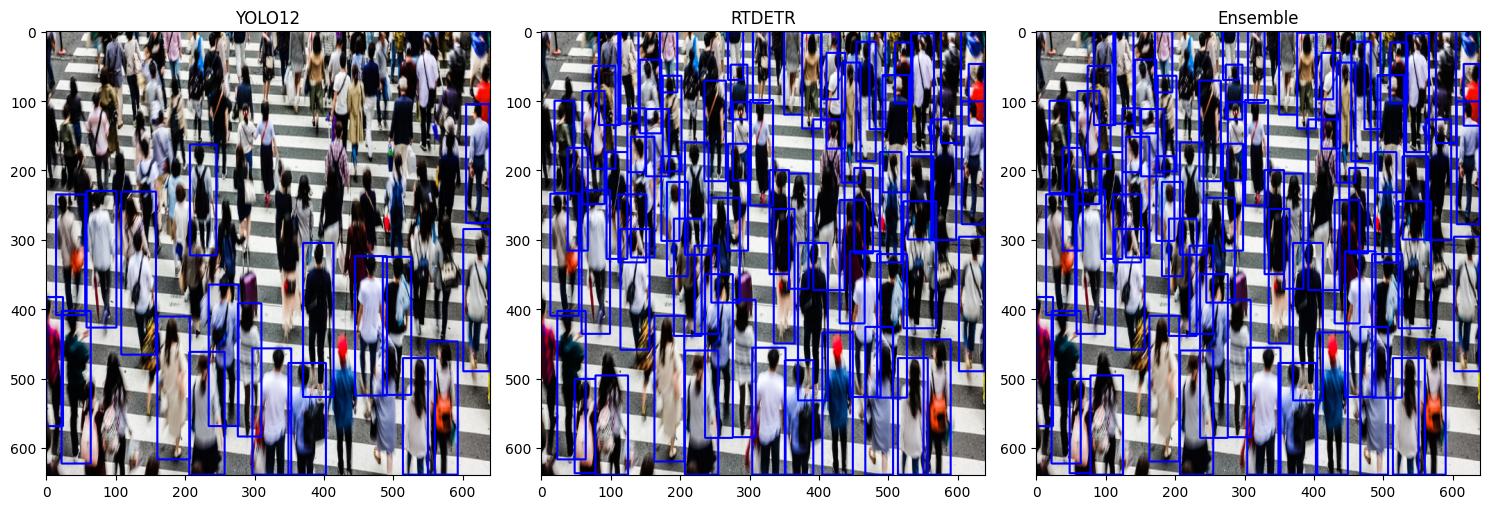

In [15]:
img_yolo = cv2.imread(img_path)
img_yolo = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_yolo = cv2.resize(img, (640, 640))

img_rtdetr = cv2.imread(img_path)
img_rtdetr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_rtdetr = cv2.resize(img, (640, 640))

img_ensemble = cv2.imread(img_path)
img_ensemble = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_ensemble = cv2.resize(img, (640, 640))

for box in out_yolo[0]:
    cv2.rectangle(img_yolo, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)

for box in out_rtdetr[0]:
    cv2.rectangle(img_rtdetr, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)

for box in out_ensemble[0]:
    cv2.rectangle(img_ensemble, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 0, 255), 2)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("YOLO12")
plt.imshow(img_yolo)

plt.subplot(1, 3, 2)
plt.title("RTDETR")
plt.imshow(img_rtdetr)

plt.subplot(1, 3, 3)
plt.title("Ensemble")
plt.imshow(img_ensemble)
plt.tight_layout()
plt.show()
